# 2. Explainability of Random Forests

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-FGC/part2.ipynb)

Now that you are visualizing the notebook in Colab, run the next cell, in order to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
3. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [ ]:
# Create a folder in your Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive

In [ ]:
!git clone https://github.com/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI.git
# or !git clone git@github.com:HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI.git   

In [ ]:
%cd Zero2Hero---Introduction-to-XAI/xai-FGC

Lastly, we need to install some of the packages we will use:

In [ ]:
!pip install fgclustering
!pip install matplotlib==3.4.3

In this Notebook we will show you different methods that can be used for interpreting Random Forest models. We will demonstrate you how to apply those methods and how to interpret the results.

<center><img src="./figures/penguins.png" width="400" /></center>

In [1]:
# Load the required packages

import joblib
import numpy as np
import pandas as pd

from fgclustering import FgClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt

from utils.utils import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
import fgclustering
fgclustering.__file__

'/Users/helena.pelin/opt/anaconda3/envs/fgclust-released/lib/python3.9/site-packages/fgclustering/__init__.py'

We will load the dataset we were using for training (processed version) and the trained Random Forest model from the previous notebook.

In [3]:
# Load the data
data_penguins = pd.read_csv('./data/data_penguins_processed.csv', index_col=0)

# Separate the target and feature columns
X_penguins = data_penguins.loc[:, data_penguins.columns != 'species']
y_penguins = data_penguins.species

# Load the model
rf = joblib.load(open('./models/random_forest_penguins.joblib', 'rb'))

## Interpreting Random Forest models with Feature Importance

### Permutation Feature Importance

In the previous courses you were introduced to Permutation Feature Importance. Now it is time to see how it works on the penguins dataset. 


In [ ]:
result = permutation_importance(rf, X_penguins, y_penguins, n_repeats=50, max_samples = 0.8, random_state=42)
plot_perm_feature_importance(result=result, data=X_penguins, title="Permutation Feature Importance")

<font color='green'>

#### Question 1: How big is the influence of the most important feature on the model performance?

<font color='grey'>

#### Your Answer: 
Permutation of the feature 'bill_length_mm' drops the accuracy by at most 0.3 (right plot), and on average 0.25 (left plot).

### Random Forest Feature Importance


An alternative for Permutation Feature Importance is the Random Forest specific Feature Importance method based on mean decrease in impurity. This Feature Importances is directly provided by the fitted attribute _feature_importances__ and is computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Lets plot the feature importance based on mean decrease in impurity:

In [ ]:
plot_feature_importance(rf.feature_importances_, names=X_penguins.columns, title="Random Forest Feature Importance")

<font color='green'>

#### Question 2: Inspect the differences between the results of the two feature importance plots. What do you notice? 
_Hint:_ Take a look at the correlation plot below

<font color='grey'>

#### Your Answer: 

1. Random Forest Feature Importance identifies more important features than the Permutation Feature Importance. 
2. It seems that the feature importance of the correlated features *flipper_length* and *body_mass* are artificially lower due to the high correlation. Random Forest Feature Importance does not seem to be affected by this correlation effect. This shows that Permutation Feature Importance results should be interpreted with great care in the presence of correlated features. 

In [ ]:
plot_correlation_matrix(X_penguins)

Even though the Random Forest Feature Importance does overcome some disadvantages of Permutation Feature Importance, it does not give us more information about the class-specific differences and further insights into the decision paths of the Random Forest model. Therefore, we developed a Random Forest specific interpretability method called Forest-Guided Clustering that leverages the tree structure of Random Forest models to get insights into the decision making process of the model. Let dive into the method... 

## Interpreting Random Forest models with Forest-Guided Clustering

**VIDEO (presentation with voice over)**


Documentation for the FGC: https://forest-guided-clustering.readthedocs.io/en/latest/

We will use FGC to gain more insights into the decision making process of the Random Forest model we trained in the previous notebook. Afterwards, we will compare the feature importance results obtained by the previous methods and with FGC.

In [4]:
# create an FGC instance
fgc = FgClustering(model=rf, data=X_penguins, target_column=y_penguins)

Interpreting RandomForestClassifier


FGC is based on the K-Medoids clustering algorithm, which requires a predefined number of clusters as input. FGC is able to optimize the number of clusters based on a scoring function, which is minimizing the model bias while restricting the model complexity. The argument _number_of_clusters_ is used to either pass the predefined number of clusters or should be left empty if optimization is desired. 

For the sake of example and since the optimization part takes some time, we will set the number of cluster equal to the number of species present in the penguins dataset.

In [5]:
# Run the fgc instance:
fgc.run(number_of_clusters=3)

Use 3 as number of cluster


FGC provides couple of ways to visualise the results and help interpret them:

- visualise global and local feature importance: features that show different and concise value distributions across clusters are defined to be globally or locally important
- reveal the decision rules of RF model by visualizing feature patterns per cluster

### Global and Local Feature importance provided by FGC

**Global feature importance** is represetned as the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). **Features, which have significantly different distributions across clusters, have a high feature importance**, while features, which have a similar feature distribution across clusters have a low feature importance.

In addition to the global feature importance, we also provide a **local feature importance**, which gives the **importance of each feature for each cluster**. For the local feature importance we pre-filter the features based on the global feature importance (_thr_pvalue_ is used for the filtering step, just as in the plots before). Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset.

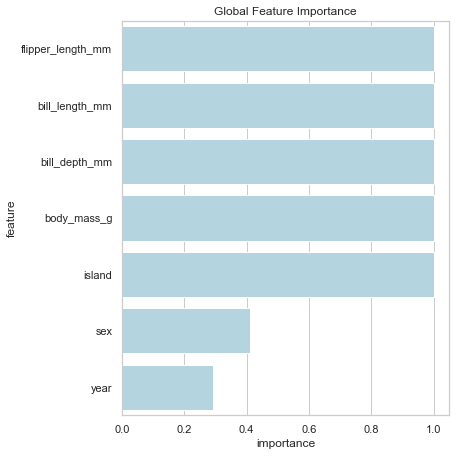

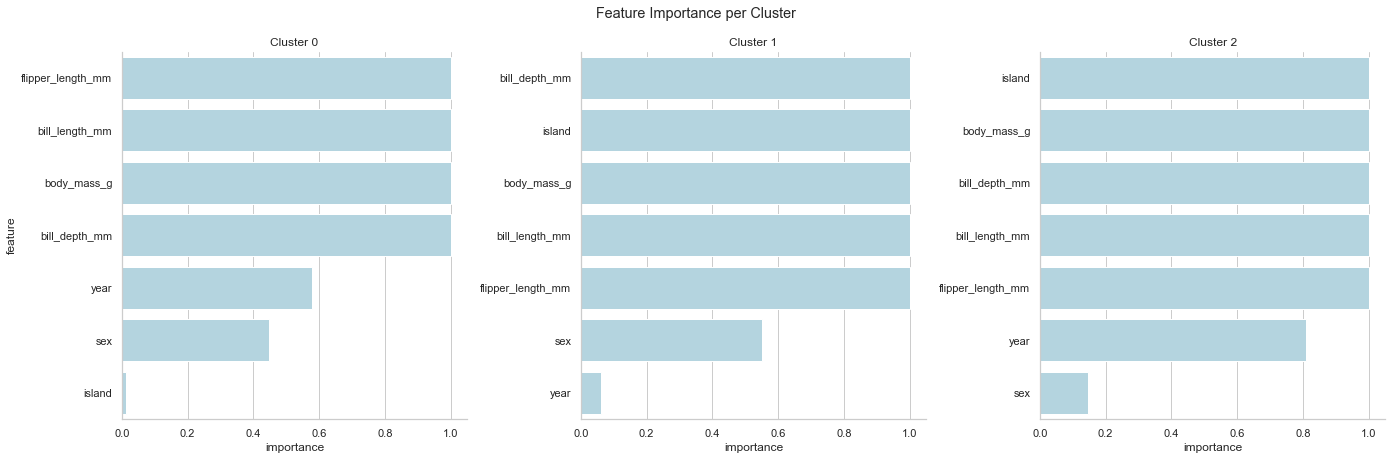

In [6]:
%matplotlib inline
# Plot global feature importance
fgc.plot_global_feature_importance()
# Plot local feature importance
fgc.plot_local_feature_importance(thr_pvalue=1) # Set thr_pvalue=1 to show all the features

<font color='green'>

#### Question 3: What do you observe when comparing the Random Forest Feature Importance and the FGC Feature Importance?


<font color='grey'>

#### Your Answer: 
The global feature importance gives us the same results as the Random Forest Feature Importance. The local feature importance reveals more information. For example, the feature *island* is important for the cluster 1 and 2, but not for the cluster 0.

### Visualizing the decision paths of the Random Forest model

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision making process of that model, in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  We can see which classes/target values fall into which cluster and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labelled samples / measurement errors. The distribution plots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

We can choose which features we want to plot by specifying the _p_-value threshold applied to the _p_-values of the features from the global feature importance calculation. The default threshold _thr_pvalue_ is set to 0.01. By selecting a lower p-value threshold, we only plot features that show high differences between cluster-wise feature distributions. 

Remember, we were transforming our target variable into integeres with the LabelEncoder instance. The resulting mapping from that process looks like this:

- Adelie = 0
- Chinstrap = 1
- Gentoo = 2


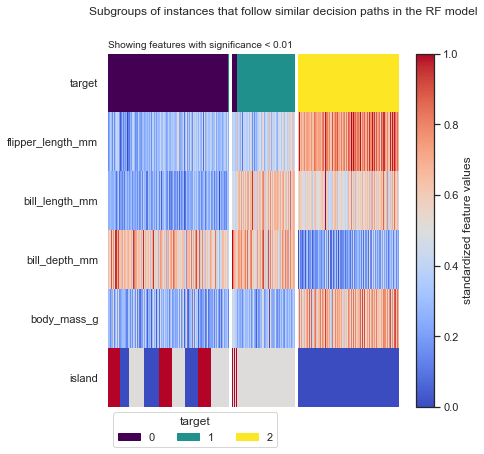

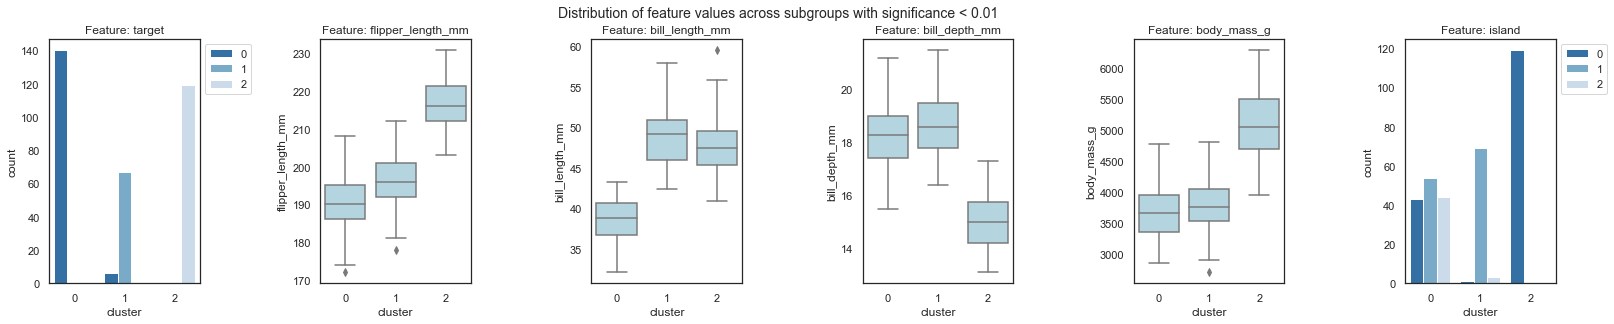

In [7]:
fgc.plot_decision_paths(thr_pvalue=0.01) # feel free to try different p-values thresholds

<font color='green'>

#### Question 4: Why are the features 'sex' and 'year' not shown on the plots above?


<font color='grey'>

#### Your Answer: 

We only show features with p-values < thr_pvalue = 0.01. This means that these two features don't show significant difference between clusters. Hence, they don't seem to play a role in the decision making process of this random forest model

<font color='green'>

#### Question 5: Try to describe species by observing the plots (Adelie = 0, Chinstrap = 1, Gentoo = 2). Use the following examples to guide you:

- What makes Gentoo different from the other two species? 
- What makes Chinstrap different from Adelie?
- ...

<center><img src="./figures/bill_length.png" width="200" /></center>


<font color='grey'>

#### Your Answer: 

- Gento has a larger body mass and smaller bill depth
- Adelie has smaller bill lenght
